In [2]:
import pandas as pd
import os
import librosa
import os
from skimage import io
import torch
import torchvision
from torch.utils.data import Dataset
import math
from sklearn.preprocessing import MinMaxScaler
from pandas import Series
import IPython.display as ipd
## Reconstructing File Paths

file_path = 'Datasets/LibriSpeech/train-clean-100.index.csv'

df = pd.read_csv(file_path)

df.columns

df.head()

df.shape


df.filepath[1]

df.filepath[1][0:38]

mine = '/home/amonajemi/amonajemi/Datasets'

df['filepath'] = df['filepath'].str[37:]

df['filepath'] = mine + df['filepath']

df['filepath'].head()

from torch.utils.data import Dataset

df.head()


class LibriSpeechData(Dataset):
    def __init__(self,df,transform = None, sampling_rate = 8000, offset=1.0, duration=5.0):
        self.duration = duration
        self.df = df[df.seconds > self.duration].reset_index()
        self.audio = self.df['filepath']
        self.identities=self.df['id']
        self.transform = transform
        self.sampling_rate = sampling_rate
        if self.transform is None:
            self.transform = torch.from_numpy # Call it as an object! Now transform is defined so 
                                                # we cn iterate through the batches. 

    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index):
        audio = self.audio[index]
        self.seconds = self.df['seconds'][index]
        self.offset = random.uniform(0,self.seconds - self.duration)
        y,  sr  = librosa.load(audio, sr=self.sampling_rate, offset=self.offset, duration=self.duration)
        # The y is the one-dimensional np.array
        #that is the amplitude of the waveform at sample t
        
        #the sr is the number of samples per second of a
        #time series.
    
        time_series = self.transform(y)
        
        return time_series, torch.tensor(self.identities[index])        

df.index # Our filtering of the dataset kept the original index. This is why you see 28437 here but the
#overall length of indexes is indeed 26504 

%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display

def waveplot(y, r):
    plt.figure(figsize=(14, 5))
    librosa.display.waveplot(y, sr=r)


def spectrogram_plot(y):
    X = librosa.stft(y)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(Xdb, sr=r, x_axis='time', y_axis='log')
    
def energy_plot(a, hop_length = 256, frame_length = 2048):
    energy = np.array([
        sum(abs(a.numpy()[i:i+frame_length]**2))
        for i in range(0, len(a.numpy()), hop_length)])
    return plt.plot(energy / energy.max()), a.min(),a.max()

## Energy Detection 

def energy_values(a, hop_length = 256, frame_length = 2048):
    energy = np.array([
        sum(abs(a.numpy()[i:i+frame_length]**2))
        for i in range(0, len(a.numpy()), hop_length)])
    return energy
def energy_values(a, hop_length = 256, frame_length = 2048):
    energy = np.array([
        sum(abs(a[i:i+frame_length]**2))
        for i in range(0, len(a), hop_length)])
    return energy

get_energy = energy_values

In [4]:
import random
Voices = pd.read_csv("/home/amonajemi/amonajemi/Datasets/VOiCES/VOiCES-room-1.index.csv")

Voices.columns

Voices['filepath'][40000]

Voices['filepath'][1][22:]

file_e = '/home/amonajemi/amonajemi/Datasets/VOiCES/Volumes/'

Voices['filepath'] = Voices['filepath'].str[22:]

Voices['filepath'] = file_e + Voices['filepath']
    

Voices = Voices[~Voices.filepath.str.contains("tele")]

len(Voices)

Voices.index = range(0,len(Voices))

Voices = Voices[(Voices.filepath.str.contains("sp_3549") & Voices.filepath.str.contains("none"))|(Voices.filepath.str.contains("sp_6241") & Voices.filepath.str.contains("none")) | (Voices.filepath.str.contains("sp_1212") & Voices.filepath.str.contains("musi")) | (Voices.filepath.str.contains("sp_6241") & Voices.filepath.str.contains("musi"))]

Voices.index = range(0,len(Voices))

filename = random.choice(Voices['filepath'])
y , sr = librosa.load(filename)




class VoicesDataSet(Dataset):
    def __init__(self,df,transform = None, sampling_rate = 8000, offset=1.0, duration=3.0):
        self.duration = duration
        self.df = df[df.seconds > self.duration].reset_index()
        self.audio = self.df['filepath']
        self.identities=self.df['id']
        self.transform = transform
        self.sampling_rate = sampling_rate
        if self.transform is None:
            self.transform = torch.from_numpy # Call it as an object! Now transform is defined so 
                                                # we cn iterate through the batches. 

    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index):
        audio = self.audio[index]
        self.seconds = self.df['seconds'][index]
        self.offset = random.uniform(0,self.seconds - self.duration)
        y,  sr  = librosa.load(audio, sr=self.sampling_rate, offset=self.offset, duration=self.duration)
        # The y is the one-dimensional np.array
        #that is the amplitude of the waveform at sample t
        
        #the sr is the number of samples per second of a
        #time series.
    
        time_series = self.transform(y)
        
        return time_series, torch.tensor(self.identities[index])


In [7]:
## Fade In / Fade Out
import statistics
def fading_in(length):
    fading_in =np.linspace(0, 1, length)
    #fading_in[int(length*.50):] = 1
    return fading_in

def fading_out(length):
    fading_out = np.linspace(0,1, length)[::-1]
    #fading_out[:int(length * .50)] = 1
    return fading_out



# VAD

def zero_runs(a):
    # Create an array that is 1 where a is 0, and pad each end with an extra 0.
    iszero = np.concatenate(([0], np.equal(a, 0).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    greatest = 0
    start = 0       # For Voices change this to the max interval again like below
    end = 0
    for interval in ranges:
        diff = interval[1] - interval[0]
        if diff > greatest:
            greatest = diff
            start = interval[0]
            end = interval[1]
    return list([start, end - 1])

def zero_runs_full(a):
    # Create an array that is 1 where a is 0, and pad each end with an extra 0.
    iszero = np.concatenate(([0], np.equal(a, 0).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges

# Step 1 : Take an instance of the Voices Class
def Voices_data_Speech(dataset_class, _data):
    data = dataset_class(_data)
    #global a
    a,b = data[random.choice(_data.index)]
    vad = VAD(a.numpy(), sr = 8000, theshold = .30)
    zero_runs_intervals = zero_runs_full(vad)
    sorted_silences = sorted(zero_runs_intervals,  key = lambda arr :  arr[1] - arr[0], reverse = True)[:2]
    # Can make a threshold here of what the requirement of length is for a silent window (eg : 4000)
    #If there is only one silence interval, then no need for the energy loop.
    max_energy = 1000
    start = 0
    end = 0
    for interval in sorted_silences:
        energy_amount = statistics.mean(get_energy(a.numpy()[interval[0] : interval[1]]))
        if energy_amount <= max_energy:
            max_energy = energy_amount
            start = interval[0]
            end = interval[1] - 1
    #plt.plot(vad)
    #plt.plot(a.numpy())
    return list([start, end])

#Voices_silent_interval = Voices_data_Speech(VoicesDataSet, Voices)

#Voices_silent_interval

#full_Voices = a.numpy()

#ipd.Audio(full_Voices[Voices_silent_interval[0] : Voices_silent_interval[1]], rate = 16000)

def one_runs(a):
    # Create an array that is 1 where a is 0, and pad each end with an extra 0.
    iszero = np.concatenate(([0], np.equal(a, 0).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    interval = []
    for i in range(len(ranges) - 1):
        start_one = ranges[i][1]
        upper = i+1
        end_one = ranges[upper][0]-1
        interval.append(start_one)
        interval.append(end_one)
    ranges_ones = np.array(interval).reshape(-1,2)
    
    return ranges_ones # sorted(ranges_ones, key = lambda arr :  arr[1] - arr[0], reverse = True)
    

# Step 1 : Take an instance of the LibriSpeech Class
def Libri_data_Speech(dataset_class, _data, padding, length_needed):
    Flag = True
    while Flag:
        data = dataset_class(_data)
        global y
        y, c  = data[random.choice(_data.index)]
        vad = VAD(y.numpy(), sr = 8000, theshold = .30)
        interval_ones = one_runs(vad)
        interval_zeros = zero_runs_full(vad)
        sorted_intervals = sorted(interval_ones, key = lambda arr : arr[1] - arr[0], reverse = True)
        new_intervals = [i for i in sorted_intervals if 40000 not in i and 0 not in i and i[1] - i[0]>=length_needed] 
        selected_interval=0
        for i in new_intervals:
            start_left = interval_zeros[np.where(interval_zeros==i[0])[0]][0][0]
            end_left = interval_zeros[np.where(interval_zeros==i[0])[0]][0][1] - 1
            start_right = interval_zeros[np.where(interval_zeros==i[1] + 1)[0]][0][0]
            end_right = interval_zeros[np.where(interval_zeros==i[1] + 1)[0]][0][1] - 1
            if end_left - start_left >=padding and end_right - start_right >=padding:
                #consider adding a mean energy requirement for each interval of padding.
                selected_interval = i
                plt.plot(vad)  # plotting vad
                plt.plot(y.numpy()) # plotting time series
                Flag = False
                break
            #return as variable
    return list([selected_interval[0] - (end_left - start_left) , selected_interval[1] + (end_right - start_right)])

#Libri_Speech = Libri_data_Speech(LibriSpeechData, df, padding = 1400, length_needed = 8000)
#print(Libri_Speech[0])
#print(Libri_Speech[1])
#Libri_Speech = y.numpy()[Libri_Speech[0] : Libri_Speech[1]] # We have the indices of the loud librispeech.
# now we 


def make_new_audio(Voices_data, Lib_data, silent_begin, silent_end, silent_interval):
    if silent_begin is not 0:
        sample_audio = Voices_data[:int(silent_begin)]
       # Voices_Segment1 = np.concatenate((sample_audio[:int(len(sample_audio) * 0.50)] , 
        #                         sample_audio[int(len(sample_audio) * 0.50):] 
          #                       * np.linspace(0,1,math.ceil(len(sample_audio) * 0.50))[::-1]))
        
        Voices_Segment1 = Voices_data[:int(silent_begin)] #* fading_out(len(Voices_data[:int(silent_begin)]))
    
    half1_silent = Voices_data[int(silent_begin) : int(statistics.mean(silent_interval))]
    fade_out_half1 = half1_silent * fading_out(len(half1_silent))
    
    Libri_audio_half1 = Lib_data[:int(math.floor(len(Lib_data) / 2))]
    Libri_audio_half1 = Libri_audio_half1 #* fading_in(len(Libri_audio_half1)) # may not need to fade here 
    
    Libri_audio_half2 = Lib_data[int(math.floor(len(Lib_data) / 2)):]
    Libri_audio_half2 = Libri_audio_half2 #* fading_out(len(Libri_audio_half2)) # may not need to fade here
    
    Libri_full = np.concatenate((Libri_audio_half1 , Libri_audio_half2))
    
    half2_silent = Voices_data[int(statistics.mean(silent_interval)):int(silent_end)]
    fade_in_half2 = half2_silent* fading_in(len(half2_silent))
    
    
    sample_audio1 = Voices_data[int(silent_end):]
    #Voices_Segment2 = np.concatenate((sample_audio1[:int(len(sample_audio1) * 0.50)] 
     #                               * np.linspace(0,1,int(len(sample_audio1) * .50)), 
      #                           sample_audio1[int(len(sample_audio1) * 0.50):]))
    
    Voices_Segment2 = Voices_data[int(silent_end):] #* fading_in(len(Voices_data[int(silent_end):]))
    if Voices_Segment1 is not None: # Put this not .all()
        new_audio = np.concatenate((Voices_Segment1, fade_out_half1,Libri_full, fade_in_half2, Voices_Segment2))
    else:
        new_audio = np.concatenate((fade_out_half1, Libri_full, fade_in_half2, Voices_Segment2))
        
    return new_audio

def audio_frames(Voices_data, Lib_data, silent_begin, silent_end, silent_interval):
    # create zeros and ones for frames 
    _Voices_seg1 = np.zeros(len(Voices_data[:int(silent_begin)]))
    _silent1 = np.zeros(len(Voices_data[int(silent_begin) : int(statistics.mean(silent_interval))]))
    _Libri = np.ones(len(Lib_data))
    _silent2 = np.zeros(len(Voices_data[int(statistics.mean(silent_interval)) : int(silent_end)]))
    _Voices_seg2 = np.zeros(len(Voices_data[int(silent_end):]))
    frames = np.concatenate((_Voices_seg1, _silent1, _Libri, _silent2, _Voices_seg2))
    #plt.plot(frames)
    return frames #one_runs(frames) return this if you want the start and end points only
    

def normalizer(data):
    series = Series(data)
    values = series.values
    values = values.reshape((len(values), 1))
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(values)
    normalized = scaler.transform(values)
    normalized = normalized.reshape(-1)
    return normalized

def get_dist_libri(n_iter):
    ratio = []
    for i in range(n_iter):
        sample = v[random.choice(mp.df.index)]
        ratio.append(sum(sample[1].numpy()) / len(sample[1]))
    return ratio


def truncate_audio_variable_length(new_audio, synthetic_frames, upper , lower = None) :
    if lower is None:
        truncate_size = upper
    else:
        truncate_size = random.randint(upper, lower)
    
    right_prop_libri = sum(synthetic_frames[0 : truncate_size]) / len(synthetic_frames[0 : truncate_size])

    left_prop_libri = sum(synthetic_frames[-1 * truncate_size : ]) / len(synthetic_frames[-1*truncate_size:])
    
    if abs(right_prop_libri - 0.50) <= abs(left_prop_libri - 0.50):
        truncated_audio = new_audio[0 : truncate_size]
        synthetic_frames_truncated_audio = synthetic_frames[0:truncate_size]
        
    else:
        truncated_audio = new_audio[-1 * truncate_size : ]
        synthetic_frames_truncated_audio = synthetic_frames[-1 * truncate_size : ]
    
    return truncated_audio , synthetic_frames_truncated_audio


def get_new_preds(preds):
    mm = []
    for i in preds:
        m = i.item()
        if m <=.50:
            mm.append(0)
        else:
            mm.append(1)
    return mm
            
        
def get_evaluations_ignoring_padding(targets, outputs, ignore_index):
    targets = targets.flatten().long().cpu().numpy()
    outputs = outputs.data.cpu().numpy()
    indexes_to_remove = np.where(targets == ignore_index)
    labels_nopad = np.delete(targets , indexes_to_remove)
    preds_nopad = np.delete(outputs , indexes_to_remove)
    accuracy_score = sklearn.metrics.accuracy_score(labels_nopad , preds_nopad)
    recall_score = sklearn.metrics.recall_score(labels_nopad , preds_nopad)
    precision_score = sklearn.metrics.precision_score(labels_nopad , preds_nopad)
    dict1 = {'Accuracy' : accuracy_score , 'Recall' : recall_score , 'Precision' : precision_score}
    return dict1

In [8]:
class Creating_audio(Dataset):
    def __init__(self, LibriSpeechData , VoicesDataSet, length_needed, padding, transform = None): #Libri, Voices)
        self.length_needed = length_needed
        self.padding = padding
        self.Voices = Voices
        self.transform = transform
        if self.transform is None:
            self.transform = torch.from_numpy
        self.VoicesDataSet = VoicesDataSet(Voices)
        self.LibriSpeechData = LibriSpeechData(df)
    
    def __len__(self):
        return len(self.VoicesDataSet)
        
    def __getitem__(self, index):

        a , b = self.VoicesDataSet[index] # indexing for the voices 
        vad = VAD(a.numpy(), sr = 8000, theshold = .30)
        zero_runs_intervals = zero_runs_full(vad)
        sorted_silences = sorted(zero_runs_intervals,  key = lambda arr :  arr[1] - arr[0], reverse = True)[:2]
            # Can make a threshold here of what the requirement of length is for a silent window (eg : 4000)
            #If there is only one silence interval, then no need for the energy loop.
        max_energy = 1000
        start = 0
        end = 0
        for interval in sorted_silences:
            energy_amount = statistics.mean(get_energy(a.numpy()[interval[0] : interval[1]]))
            if energy_amount <= max_energy:
                max_energy = energy_amount
                start = interval[0]
                end = interval[1] - 1

        Voices_Silent_interval = list([start , end ])

        full_Voices = a.numpy()

        Flag = True
        data = self.LibriSpeechData
    
        while Flag:
            y, c  = data[random.choice(data.df.index)]
            vad = VAD(y.numpy(), sr = 8000, theshold = .30)
            interval_ones = one_runs(vad)
            interval_zeros = zero_runs_full(vad) # Reverse = False for the short Libri Segments, True for the long Libri Segments                             
            sorted_intervals = sorted(interval_ones, key = lambda arr : arr[1] - arr[0], reverse = False)
            new_intervals = [i for i in sorted_intervals if 40000 not in i and 0 not in i and i[1] - i[0]>=self.length_needed]
            if new_intervals:
                intervals_passed = []
                selected_interval=0
                for i in new_intervals:
                    start_left = interval_zeros[np.where(interval_zeros==i[0])[0]][0][0]
                    end_left = interval_zeros[np.where(interval_zeros==i[0])[0]][0][1] - 1
                    start_right = interval_zeros[np.where(interval_zeros==i[1] + 1)[0]][0][0]
                    end_right = interval_zeros[np.where(interval_zeros==i[1] + 1)[0]][0][1] - 1
                    if end_left - start_left >=self.padding and end_right - start_right >=self.padding:
                        full_interval = list([i[0] - (end_left - start_left) , i[1] + (end_right - start_right)])
                        #if full_interval[1] - full_interval[0]<=22000:
                            #need this length requirement to make sure LibriSpeech does not dominate
                        intervals_passed.append(full_interval)
                if intervals_passed:
                    r_interval = random.choice(intervals_passed)
                    Libri_Speech = y.numpy()[r_interval[0] : r_interval[1]]
                    Flag = False

        new_audio = make_new_audio(full_Voices, Libri_Speech, Voices_Silent_interval[0], Voices_Silent_interval[1], Voices_Silent_interval)


        synthetic_frames = audio_frames(full_Voices, Libri_Speech, Voices_Silent_interval[0], Voices_Silent_interval[1], Voices_Silent_interval)

        new_audio , synthetic_frames = truncate_audio_variable_length(new_audio, synthetic_frames, upper = 28000, lower=None)
        
        new_audio = self.transform(normalizer(new_audio))
        
        synthetic_frames = self.transform(synthetic_frames)


        return new_audio.float() , synthetic_frames # squeeze it for the interval [ ] task

In [ ]:
import warnings
import sklearn
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [9]:
v = Creating_audio(LibriSpeechData, VoicesDataSet, length_needed = 3000, padding = 700,
                   transform = None)

In [10]:
mp = VoicesDataSet(Voices)

In [11]:
sample = v[random.choice(mp.df.index)] # divide by zero in double scalars

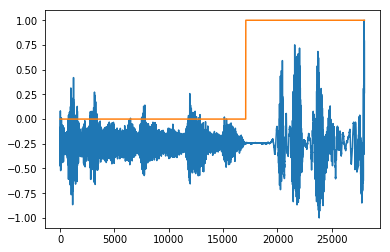

In [12]:
plt.plot(sample[0].numpy())
plt.plot(sample[1].numpy())

In [13]:
# Train / Test Split 
from torch.utils.data.sampler import SubsetRandomSampler
batch_size = 24
validation_split = .2
shuffle_dataset = True
random_seed= 42
dataset_size = len(v) # len of the voices dataset 
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed) # These will perform what is assigned to validation and what is 
                        #assigned to training
    np.random.shuffle(indices)
# grab indices 
train_indices, val_indices = indices[split:], indices[:split]


# Creating PT data samplers and loaders:

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)



In [ ]:
# Changing default collate to pack data into tuple of variable-length tensors 
torch.utils.data.dataloader.default_collate = (lambda default_collate = torch.utils.data.dataloader.default_collate: lambda batch: batch if all(map(torch.is_tensor, batch)) and any([tensor.size() != batch[0].size() for tensor in batch]) else default_collate(batch))()

In [14]:
torch.utils.data.dataloader.default_collate = torch.utils.data.dataloader.default_collate

In [15]:
train_loader = torch.utils.data.DataLoader(v, batch_size=batch_size, 
                                           sampler=train_sampler, num_workers=4, drop_last = True)
validation_loader = torch.utils.data.DataLoader(v, batch_size=batch_size,
                                                sampler=valid_sampler, num_workers=4, drop_last = True)

In [17]:
from torch import nn
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence
from torch.nn.utils.rnn import pad_sequence
from torch import device
from torch import optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score
from datetime import datetime
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class Variable_LSTM(nn.Module):
    def __init__(self, input_size , hidden_size , num_layers, output_dim = 1 , batch_size = batch_size):
        super(Variable_LSTM , self).__init__()
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
        self.to_linear = nn.Linear(hidden_size , output_dim)
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        
    def init_hidden(self):
        
        #initializaing hidden state to zeros
        
        return (Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)),
                Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)))
    
    def forward(self, x):
        # Pack the padded sequence here
        packed_time_series = pack_padded_sequence(x, self.get_length_tensor(x), batch_first=True)
        
        # Feed the packed sequence here
        
        lstm_out , self.hidden = self.lstm(packed_time_series.float())
        
        # pad_packed_sequence to reshape the output after the lstm 
        
        padded_output, output_lens = pad_packed_sequence(lstm_out, batch_first=True)
        
        #feed padded_output to linear layer
        
        seq = self.to_linear(padded_output)
        
        # Pass the entirety of the lstm output for the seq2seq predictions
        #y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
        
        pred = torch.sigmoid(seq)
    
        return pred
    
    def get_length_tensor(self, x):
        lengths = torch.Tensor([len(i) for i in x])
        lengths = torch.sort(lengths, descending = True)[0]
        
        return lengths
    

In [18]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_dim = 2, batch_size = batch_size):
        super(LSTM , self).__init__()
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.rnn_state = None
        self.lstm = nn.LSTM(self.input_size , self.hidden_size , self.num_layers, batch_first = True)
        self.to_linear = nn.Linear(self.hidden_size, output_dim)
    def repackage_rnn_state(self):

        self.rnn_state = self._detach_rnn_state(self.rnn_state)

    def _detach_rnn_state(self, h):
        
        if isinstance(h, torch.Tensor):
            return h.detach()
        else:
            return tuple(self._detach_rnn_state(v) for v in h)
    
    
    def forward(self, x):
        lstm_out, self.rnn_state = self.lstm(x , self.rnn_state)
        logits = self.to_linear(lstm_out)
        scores = F.softmax(logits, dim = 2)
        return scores
    

In [19]:
def split_batch(seq_batch, labels_batch, bptt):
    """
    Split torch.tensor batch by bptt steps, 
    Split seqence dim by bptt
    """
    seq_batch_splits = seq_batch.split(bptt,dim=1)
    labels_batch_splits = labels_batch.split(bptt, dim=1)
    return seq_batch_splits, labels_batch_splits

In [247]:
network = LSTM(input_size = 1, hidden_size = 128, num_layers = 2 , batch_size = batch_size)
network.to(device)
num_epochs = 20
criterion = nn.CrossEntropyLoss()#ignore_index = 2)
optimizer = optim.Adam(network.parameters(), lr = 0.001)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
clip = 1

In [ ]:
for epoch in range(num_epochs):
     
    running_loss_train , accuracy_train, running_recall_train = 0 , 0 , 0
    
    network.train()
    
    for batch_idx, batch in enumerate(train_loader):   
        
        optimizer.zero_grad()
        
        network.rnn_state = None
        
        time_series , labels = batch
        new_time_series, new_labels = time_series.to(device), labels.to(device)
        
        bptt_loss = 0
        bptt_recall = 0
        
        bptt_audio_chunks, bptt_label_chunks = split_batch(new_time_series, new_labels.long(),50)
        
        bptt_audio_chunks = torch.cat(bptt_audio_chunks,0).split(672*4, dim = 0)
        
        bptt_label_chunks = torch.cat(bptt_label_chunks,0).split(672*4, dim = 0)
        
        #shape is now torch.size([batch_size , time_steps, num_features])
        #num_features will be 1 after we unsqueeze
        #now we learn through the batch chunks
        
        for idx_chunk , audio_chunk in enumerate(bptt_audio_chunks):
            
            optimizer.zero_grad()
            
            preds = network(audio_chunk.unsqueeze(2))
            preds = preds.view(preds.shape[0]*preds.shape[1], preds.shape[2])
            
            new_labels = bptt_label_chunks[idx_chunk]
            
            train_loss = criterion(preds, new_labels.flatten())
            bptt_loss += train_loss.item() / new_time_series.shape[0]
            
            train_loss.backward()
            
            torch.nn.utils.clip_grad_norm_(network.parameters(),clip)
            
            optimizer.step()
            
            network.repackage_rnn_state()
            
            bptt_recall+=recall_score(new_labels.flatten().cpu(), torch.max(preds, 1)[1].cpu())
            
        if batch_idx%1==0:
            print('Epoch : %d | BatchID : %d | Train Loss : %.3f | Recall : %.3f ' % 
                  (epoch , batch_idx, bptt_loss / len(bptt_audio_chunks) , 
                   bptt_recall / len(bptt_audio_chunks)))

In [ ]:
val_loss_list, epoch_list , accuracy_list = [], [], []  # val_accuracy_list

print("Training...\n")

for epoch in range(num_epochs):
    
    #scheduler.step()
    
    print('Epoch: ', epoch)#'LR: ', scheduler.get_lr())
    
    print('\n')
    
    running_loss_train , accuracy_train = 0 , 0
    
    network.hidden = network.init_hidden()
    
    for batch_idx, batch in enumerate(train_loader):
        
        #at every step, we send the input and target to the GPU
        
        time_series , labels = batch
        
        #paddings for batches and the labels
        
        new_time_series = pad_sequence([torch.Tensor(t.float()) for t in time_series]).t()
        
        new_labels = pad_sequence([torch.Tensor(t.float()) for t in labels], padding_value = 2).t()
        
        new_time_series, new_labels = new_time_series.to(device), new_labels.to(device)
        
        optimizer.zero_grad()
        
        # forward pass feeding the padded sequence
        
        preds = network(new_time_series.unsqueeze(2))
        
        preds = preds.view(preds.shape[0]*preds.shape[1], preds.shape[2])
        
        train_loss = criterion(preds, new_labels.flatten().long())
        
        train_loss.backward()
        
        # gradient clipping here just before the parameter updates, clips inplace
        
        torch.nn.utils.clip_grad_norm_(network.parameters(),clip)
        
        optimizer.step()
        
        running_loss_train+=train_loss.detach().item()/new_time_series.shape[0]
        
        _ ,predictions = torch.max(preds,1)
        
        metrics = get_evaluations_ignoring_padding(new_labels, predictions, 2)
        
        accuracy_train+=metrics['Accuracy']
        

        if batch_idx%100==0:
            print('Epoch : %d | BatchID : %d | Train Loss : %.3f | Train Acc : %.3f ' % 
                  (epoch , batch_idx, train_loss.item() / new_time_series.shape[0] ,
                   metrics['Accuracy']))
     
   # ----------------- VALIDATION  ----------------- 
    
    print("Validation....")
    
    with torch.no_grad():
        
        network.eval()
        
        network.hidden = network.init_hidden() # not stateful
        
        running_loss_val, accuracy_val, recall_val , precision_val = 0 , 0 , 0 , 0
        
        for batch_idx_val, batch_val in enumerate(validation_loader):
                                   
            time_series_val , labels_val = batch_val
            
            new_time_series_val = pad_sequence([torch.Tensor(t.float()) for t in time_series_val]).t()
            
            new_labels_val = pad_sequence([torch.Tensor(t.float()) for t in labels_val], padding_value = 2).t()
            
            new_time_series_val = new_time_series_val.to(device)
            
            new_labels_val = new_labels_val.to(device)
            
            preds_val = network(new_time_series_val.unsqueeze(2))
            
            preds_val = preds_val.view(preds_val.shape[0]*preds_val.shape[1], preds_val.shape[2])
            
            val_loss = criterion(preds_val, new_labels_val.flatten().long())
            
            _ ,predictions_val = torch.max(preds_val,1)
            
            running_loss_val+=val_loss.detach().item() / new_time_series_val.shape[0]
            
            metrics_val = get_evaluations_ignoring_padding(new_labels_val , predictions_val , 2)
            
            accuracy_val+= metrics_val['Accuracy']
            
            recall_val+= metrics_val['Recall']
            
            precision_val+=metrics_val['Precision']
            
            
        network.train()
        
        print('Epoch : %d | Train Loss : %.3f | Train Acc : %.3f | Val Loss : %.3f | Val Acc : %.3f | Recall : %.3f | Precision : %.3f' 
              % (
                  epoch , 
                  running_loss_train / len(train_loader),
                  accuracy_train / len(train_loader),
                  running_loss_val / len(validation_loader),
                  accuracy_val / len(validation_loader),
                  recall_val / len(validation_loader),
                  precision_val / len(validation_loader)
              )
          )
                    
    epoch_list.append(epoch)
    val_loss_list.append(running_loss_val / len(validation_loader))
    accuracy_list.append(accuracy_val / len(validation_loader))
      
    




In [ ]:
# visualization loss
plt.plot(epoch_list, val_loss_list)
plt.xlabel("# of epochs")
plt.ylabel("Loss")
plt.title("LSTM: Loss vs # epochs")
plt.show()


# visualization accuracy
plt.plot(epoch_list, accuracy_list, color="red")
plt.xlabel("# of epochs")
plt.ylabel("Accuracy")
plt.title("LSTM: Accuracy vs # epochs")
plt.show()

In [ ]:
#print(network.lstm)
#print(network.lstm.weight_hh_l0)
#print(network.lstm._all_weights)
#print(network.to_linear.weight)
torch.save(network.state_dict(), 'LSTM_parameters.pt')